In [ ]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except:
    HAS_LGBM = False

In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
train = pd.read_csv(filename, encoding='latin1')


# Show first 5 rows
print("Dataset Preview:")
print(train.head())

Saving Liver Patient Dataset (LPD)_train.csv to Liver Patient Dataset (LPD)_train.csv
Saving test.csv.xlsx to test.csv.xlsx
Dataset Preview:
   Age of the patient Gender of the patient  Total Bilirubin  \
0                65.0                Female              0.7   
1                62.0                  Male             10.9   
2                62.0                  Male              7.3   
3                58.0                  Male              1.0   
4                72.0                  Male              3.9   

   Direct Bilirubin   Alkphos Alkaline Phosphotase  \
0               0.1                          187.0   
1               5.5                          699.0   
2               4.1                          490.0   
3               0.4                          182.0   
4               2.0                          195.0   

    Sgpt Alamine Aminotransferase  Sgot Aspartate Aminotransferase  \
0                            16.0                             18.0   
1        

In [ ]:
print("\nDataset Info:")
print(train.info())

print("\nMissing Values:")
print(train.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30691 entries, 0 to 30690
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Age of the patient                    30689 non-null  float64
 1   Gender of the patient                 29789 non-null  object 
 2   Total Bilirubin                       30043 non-null  float64
 3   Direct Bilirubin                      30130 non-null  float64
 4    Alkphos Alkaline Phosphotase         29895 non-null  float64
 5    Sgpt Alamine Aminotransferase        30153 non-null  float64
 6   Sgot Aspartate Aminotransferase       30229 non-null  float64
 7   Total Protiens                        30228 non-null  float64
 8    ALB Albumin                          30197 non-null  float64
 9   A/G Ratio Albumin and Globulin Ratio  30132 non-null  float64
 10  Result                                30691 non-null  int64  
dtype

In [ ]:
target_col = 'Result'   # Target column
# Convert the 'Result' column: 2 = Liver Disease (1), 1 = No Disease (0)
train[target_col] = train[target_col].apply(lambda x: 1 if x == 2 else 0)

# Separate features and target
X = train.drop(columns=[target_col])
y = train[target_col]

In [ ]:
# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

print("\nNumeric Columns:", numeric_cols)
print("Categorical Columns:", cat_cols)

# Fill missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

if numeric_cols:
    X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])
if cat_cols:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Encode categorical columns
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))


Numeric Columns: ['Age of the patient', 'Total Bilirubin', 'Direct Bilirubin', '\xa0Alkphos Alkaline Phosphotase', '\xa0Sgpt Alamine Aminotransferase', 'Sgot Aspartate Aminotransferase', 'Total Protiens', '\xa0ALB Albumin', 'A/G Ratio Albumin and Globulin Ratio']
Categorical Columns: ['Gender of the patient']



--- EDA: Plotting Feature Distributions ---


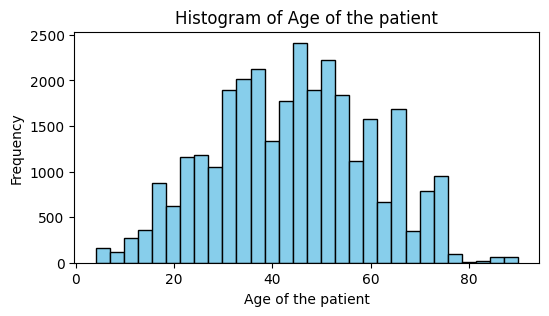

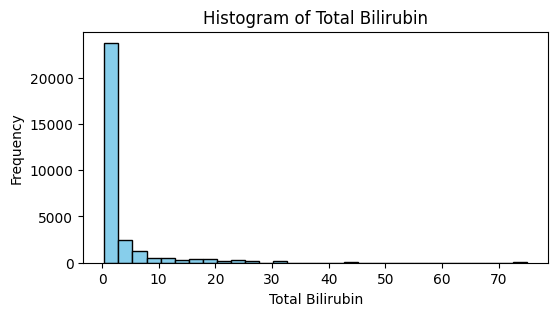

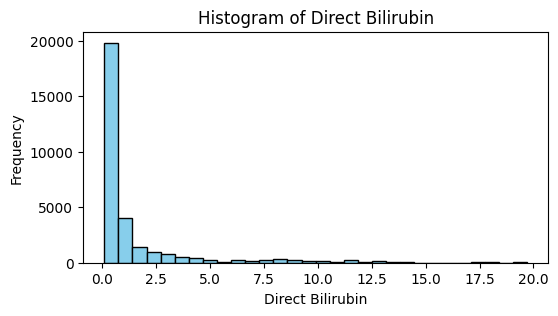

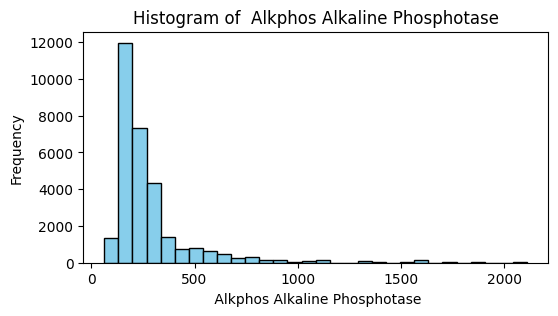

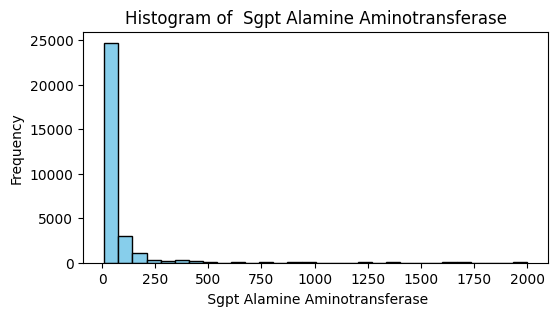

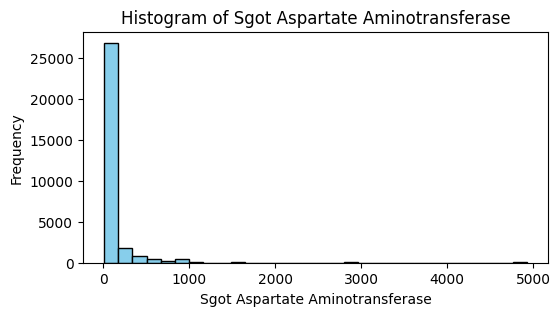

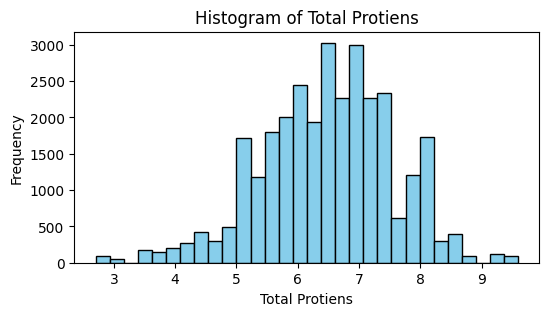

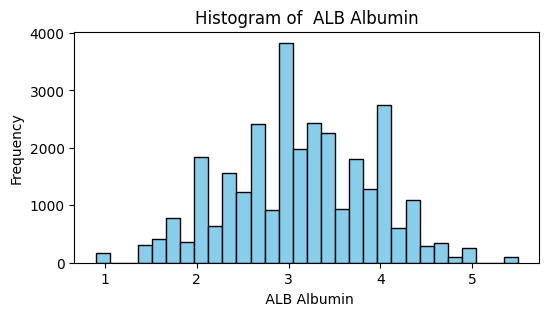

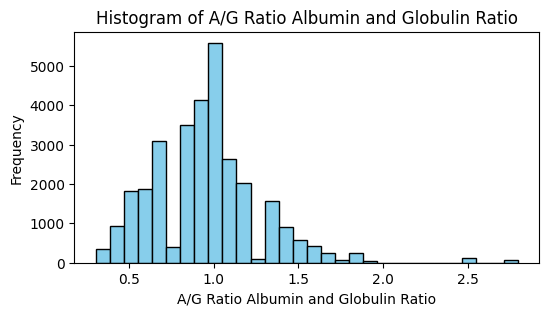

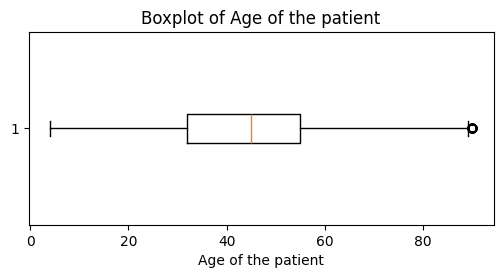

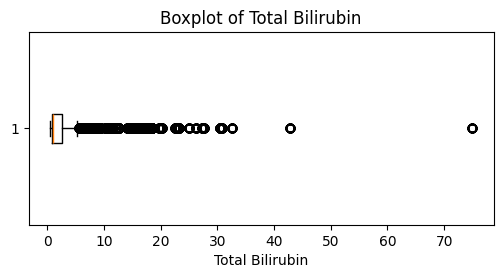

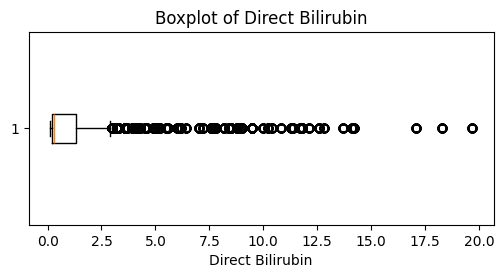

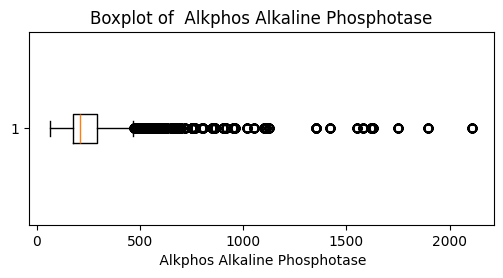

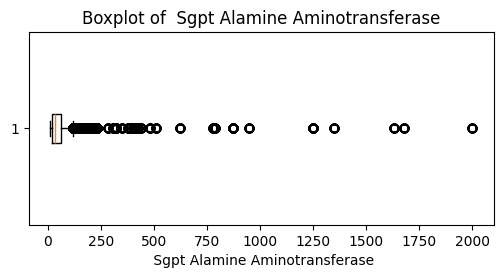

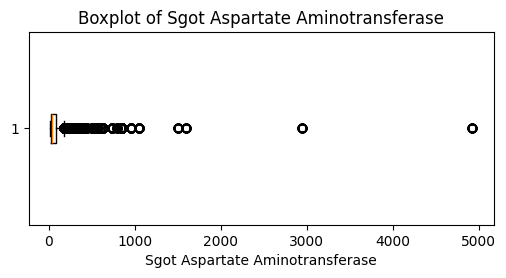

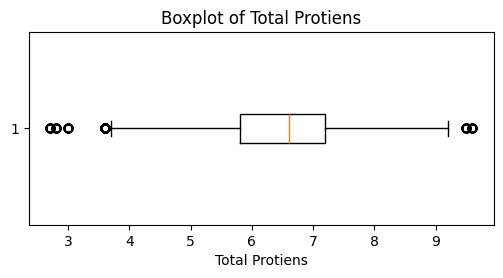

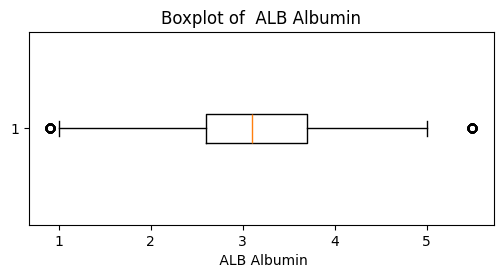

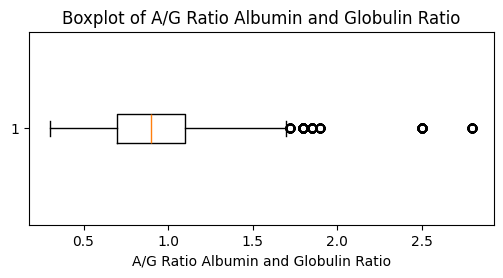

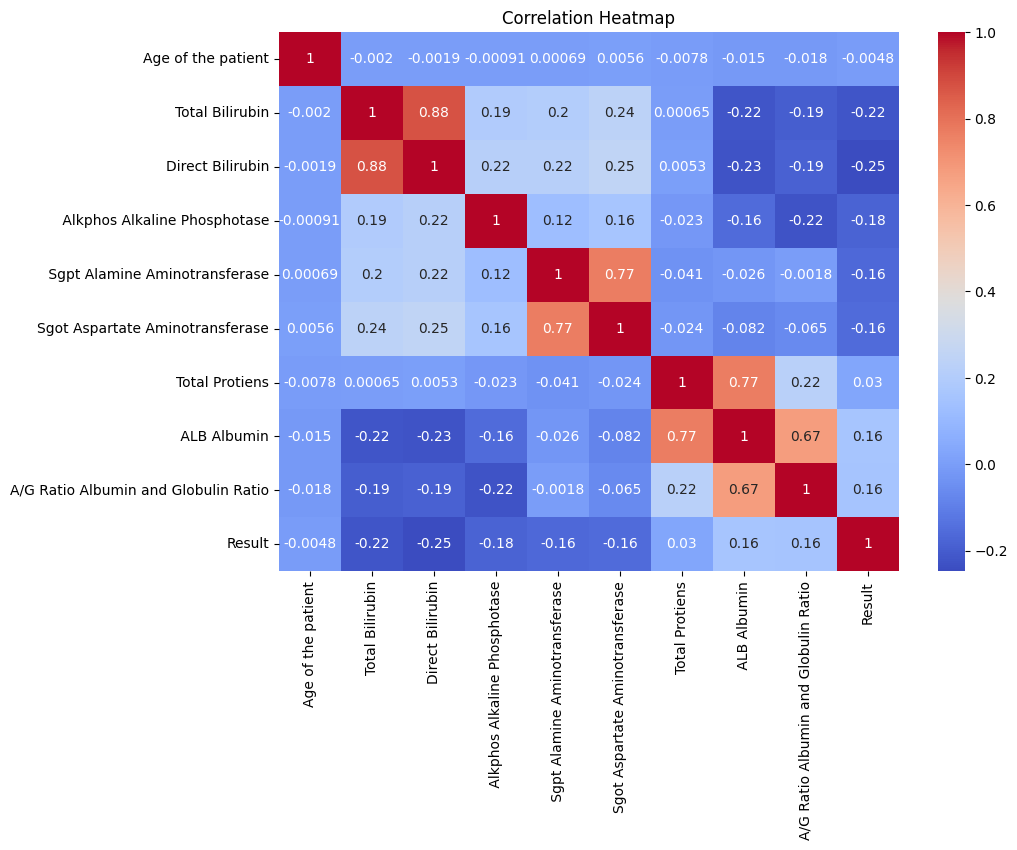

In [ ]:
print("\n--- EDA: Plotting Feature Distributions ---")

# Histogram for each numeric feature
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(X[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplots for numeric features
for col in numeric_cols:
    plt.figure(figsize=(6,2.5))
    plt.boxplot(X[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,7))
sns.heatmap(pd.concat([X[numeric_cols], y], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
outlier_mask = pd.DataFrame(False, index=X.index, columns=numeric_cols)

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_mask[col] = (X[col] < lower) | (X[col] > upper)

print("\nNumber of rows with outliers:", outlier_mask.any(axis=1).sum())
X = X.loc[~outlier_mask.any(axis=1)].reset_index(drop=True)
y = y.loc[~outlier_mask.any(axis=1)].reset_index(drop=True)
print("After removing outliers:", X.shape)


Number of rows with outliers: 10119
After removing outliers: (20572, 10)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTrain shape:", X_train.shape)
print("Validation shape:", X_val.shape)



Train shape: (16457, 10)
Validation shape: (4115, 10)


In [ ]:
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])


In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
majority = df_train[df_train[target_col] == 0]
minority = df_train[df_train[target_col] == 1]
# Simple oversampling of minority class
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
df_balanced = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X_train = df_balanced.drop(columns=[target_col])
y_train = df_balanced[target_col]
print("\nAfter Oversampling:")
print(y_train.value_counts())



After Oversampling:
Result
1    10040
0    10040
Name: count, dtype: int64


In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 Important Features:")
print(importances.head(10))

top_features = importances.head(8).index.tolist()
X_train = X_train[top_features]
X_val = X_val[top_features]



Top 10 Important Features:
 Alkphos Alkaline Phosphotase           0.172999
Sgot Aspartate Aminotransferase         0.155699
 Sgpt Alamine Aminotransferase          0.141429
Total Protiens                          0.124934
 ALB Albumin                            0.118434
Total Bilirubin                         0.107477
A/G Ratio Albumin and Globulin Ratio    0.106275
Direct Bilirubin                        0.068897
Age of the patient                      0.003384
Gender of the patient                   0.000472
dtype: float64


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42)
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
if HAS_LGBM:
    models["LightGBM"] = LGBMClassifier(random_state=42)



Training Logistic Regression...
              precision    recall  f1-score   support

           0       0.73      0.52      0.61      2511
           1       0.48      0.70      0.57      1604

    accuracy                           0.59      4115
   macro avg       0.61      0.61      0.59      4115
weighted avg       0.63      0.59      0.59      4115


Training Naive Bayes...
              precision    recall  f1-score   support

           0       0.74      0.34      0.47      2511
           1       0.44      0.82      0.57      1604

    accuracy                           0.53      4115
   macro avg       0.59      0.58      0.52      4115
weighted avg       0.63      0.53      0.51      4115


Training KNN...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2511
           1       0.98      0.98      0.98      1604

    accuracy                           0.98      4115
   macro avg       0.98      0.98      0.98      4115

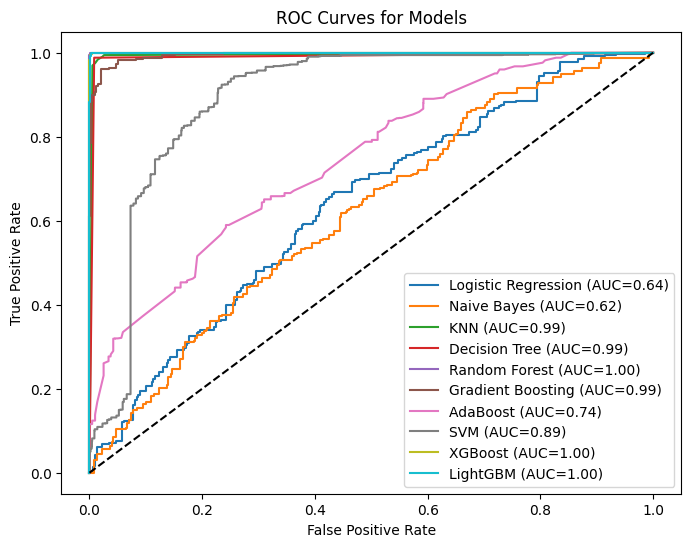

In [ ]:
results = {}

plt.figure(figsize=(8,6))
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, "predict_proba") else np.zeros(len(y_pred))

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results[name] = [acc, prec, rec, f1, auc]

    # Print classification report
    print(classification_report(y_val, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

# Plot all ROC curves
plt.plot([0,1],[0,1],'--', color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()


In [ ]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]).T
print("\nModel Performance Comparison:")
print(results_df.sort_values(by="ROC-AUC", ascending=False))


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Random Forest        0.999028   0.999376  0.998130  0.998752  0.999997
XGBoost              0.997570   0.996264  0.997506  0.996885  0.999942
LightGBM             0.997327   0.994413  0.998753  0.996579  0.999910
Gradient Boosting    0.959660   0.925948  0.974439  0.949575  0.994987
KNN                  0.984690   0.977090  0.983791  0.980429  0.994241
Decision Tree        0.990279   0.986924  0.988155  0.987539  0.989865
SVM                  0.814095   0.691465  0.944514  0.798419  0.891905
AdaBoost             0.632321   0.521036  0.702618  0.598354  0.742518
Logistic Regression  0.589064   0.481290  0.697631  0.569611  0.636432
Naive Bayes          0.525638   0.441335  0.816085  0.572867  0.618260


In [ ]:
best_model_name = results_df.sort_values(by="ROC-AUC", ascending=False).index[0]
best_model = models[best_model_name]
print(f"\n Best Model: {best_model_name}")

import joblib

# Save the best model locally
joblib.dump(best_model, "best_model.pkl")
print(" Model saved successfully as 'best_model.pkl'")

# Optional: download from Colab
from google.colab import files
files.download("best_model.pkl")

best_model_name = results_df.sort_values(by="ROC-AUC", ascending=False).index[0]
print(f"\n Best Model: {best_model_name}")




 Best Model: Random Forest
 Model saved successfully as 'best_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Best Model: Random Forest
